In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy.integrate import solve_ivp

# Add parent directory to sys.path
from pathlib import Path
current_path = Path.cwd()
parent_dir = current_path.parent.parent
sys.path.append(str(parent_dir))

from src.transfer_learning import compute_H_and_dH_dt, analytically_compute_weights
from src.utils_plot import plot_loss_and_all_solution, plot_transfer_learned_and_analytical
from src.load_save import load_run_history

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [3]:
def check_versions_and_device():
  # set the device to the GPU if it is available, otherwise use the CPU
  current_dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  !nvidia-smi
  return current_dev

# set a global device variable to use in code
dev = check_versions_and_device()
print(dev)

Tue Mar  5 12:19:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   42C    P8              N/A /  20W |   1622MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
file_name = "last_test_big_2121449"
equation_name = "linear_exemple1"

trained_model, \
x_range, \
iterations, \
hid_lay, \
num_equations, \
num_heads, \
loss_hist, \
alpha_list, \
A_list, \
v_list, \
force_list = load_run_history(equation_name, file_name, dev, prev=False)

force_list = [
    lambda t, alpha=a: torch.vstack([2*torch.sin(t), alpha*(torch.cos(t)-torch.sin(t))]).T.double()
    if not isinstance(t, (float, int))
    else np.array([2*np.sin(t), alpha*(np.cos(t)-np.sin(t))]).T
    for a in alpha_list
]

Force change with time


In [5]:
# function to get A for alpha value and DHO equation
def get_A(alpha):
    return torch.tensor([[2., -1.], [1-alpha, alpha]], device=dev).double() 

# Numerical solution
def double_coupled_equation(t, y, A, force):
    return np.array([force(t)[..., 0].item()- A[0][1] * y[1] - A[0][0] * y[0],
                     force(t)[..., 1].item() - A[1][0] * y[0] - A[1][1] * y[1]])

r_tol = 1e-4
numerical_sol_fct_radau = lambda x, v, A, force: (solve_ivp(double_coupled_equation, [x_range[0], x_range[1]],
                                                  v.squeeze(), args=(A, force), t_eval=x.squeeze(), method="Radau", rtol=r_tol).y)

numerical_sol_fct_rk45 = lambda x, v, A, force: (solve_ivp(double_coupled_equation, [x_range[0], x_range[1]],
                                                    v.squeeze(), args=(A, force), t_eval=x.squeeze(), method="RK45", rtol=r_tol).y)

numerical_sol_fct_lsoda = lambda x, v, A, force: (solve_ivp(double_coupled_equation, [x_range[0], x_range[1]],
                                                    v.squeeze(), args=(A, force), t_eval=x.squeeze(), method="LSODA", rtol=r_tol).y)

numerical_methods = {"RK45": numerical_sol_fct_rk45, "Radau": numerical_sol_fct_radau}

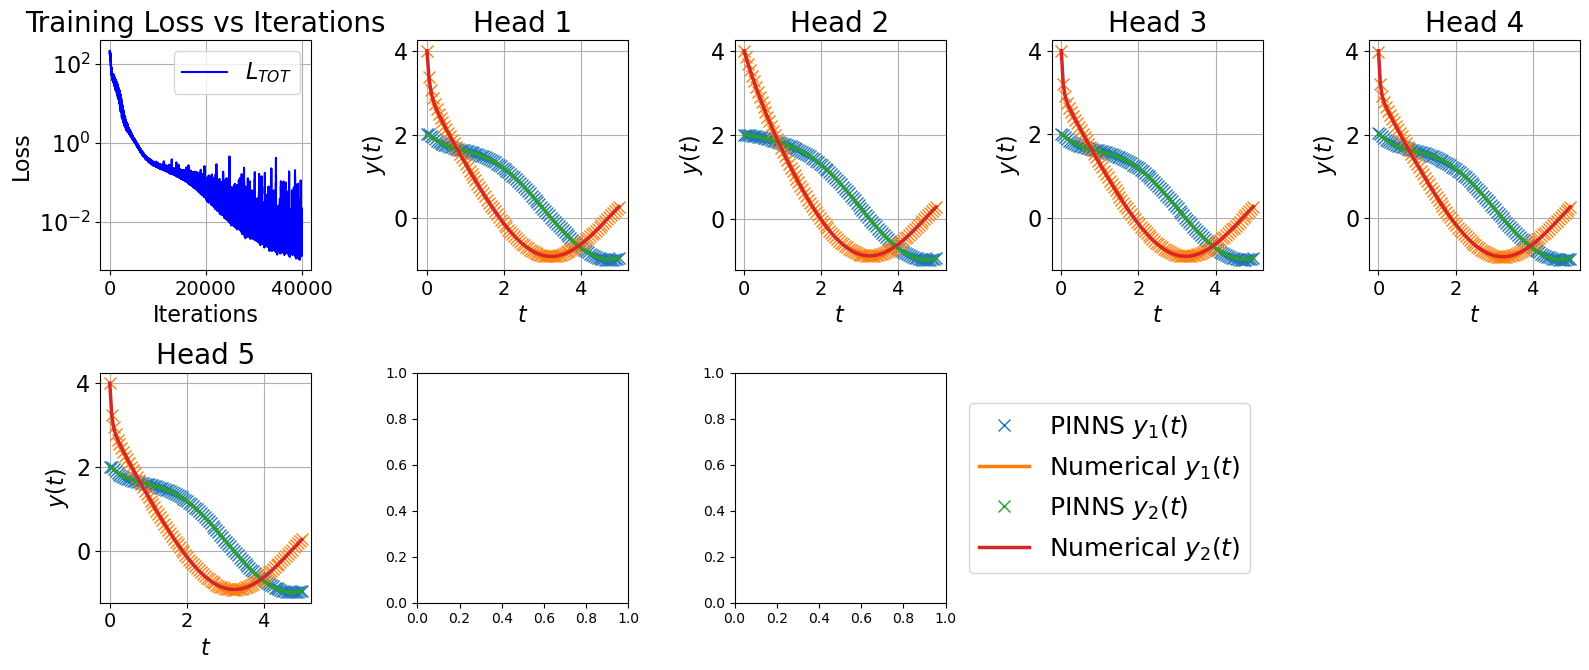

In [6]:
plot_loss_and_all_solution(x_range=x_range, true_functs=numerical_sol_fct_radau,
                           trained_model=trained_model, v_list=v_list, A_list=A_list,
                           force=force_list, train_losses=loss_hist, device=dev)

Time to compute H and dH_dt:  4.584 seconds
Time to compute weights (given H and dH_dt):  18.259 seconds
mean 0.0003426899795544991
max 0.0011796758803672702
mean 0.0003268910499862717
max 0.0012072292021869657


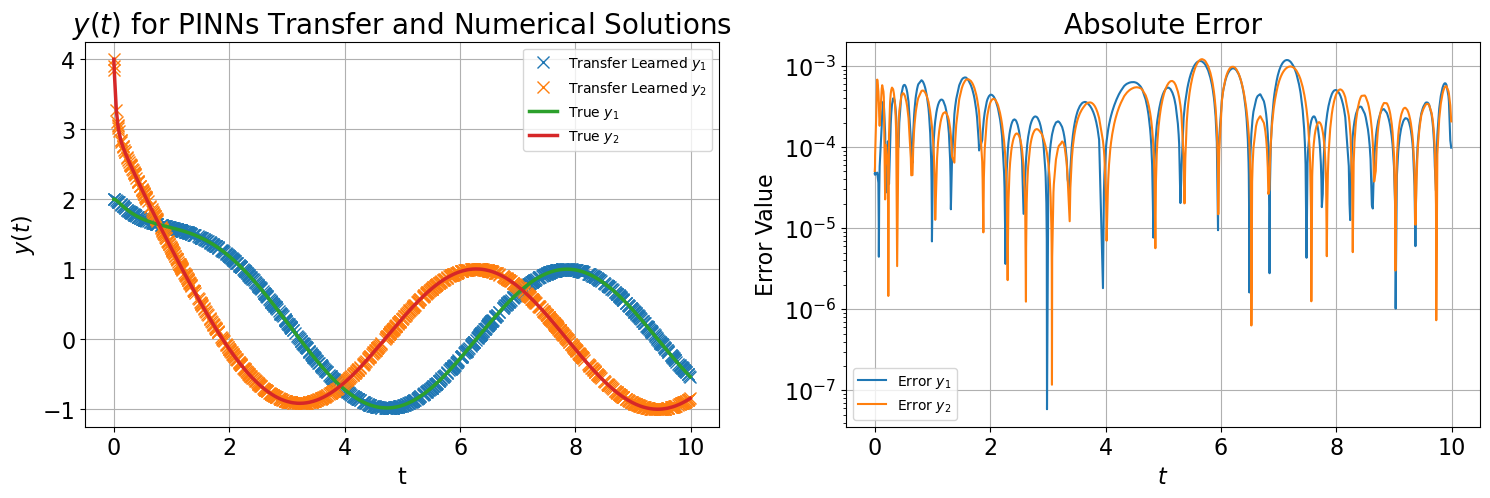

In [7]:
# forward pass to extract H
size = 1024
H, H_0, dH_dt_new, t_eval = compute_H_and_dH_dt(x_range[0], x_range[1], trained_model, num_equations, hid_lay, size, dev)

# choose an initial condition and set of coefficients that were trained on
v = v_list[2]
A = A_list[2]
force = force_list[2]
M_inv, W_out, force_terms, total_time = analytically_compute_weights(dH_dt_new, H, H_0, t_eval,
                                                                     v, A, force)
plot_transfer_learned_and_analytical(H, W_out, t_eval, v, A, force,
                                     num_equations, numerical_sol_fct_radau)

Time to compute weights (given H and dH_dt):  0.229 seconds
mean 0.053043479822022066
max 0.4997919017988415
mean 0.05305563461876884
max 0.5001668166058519


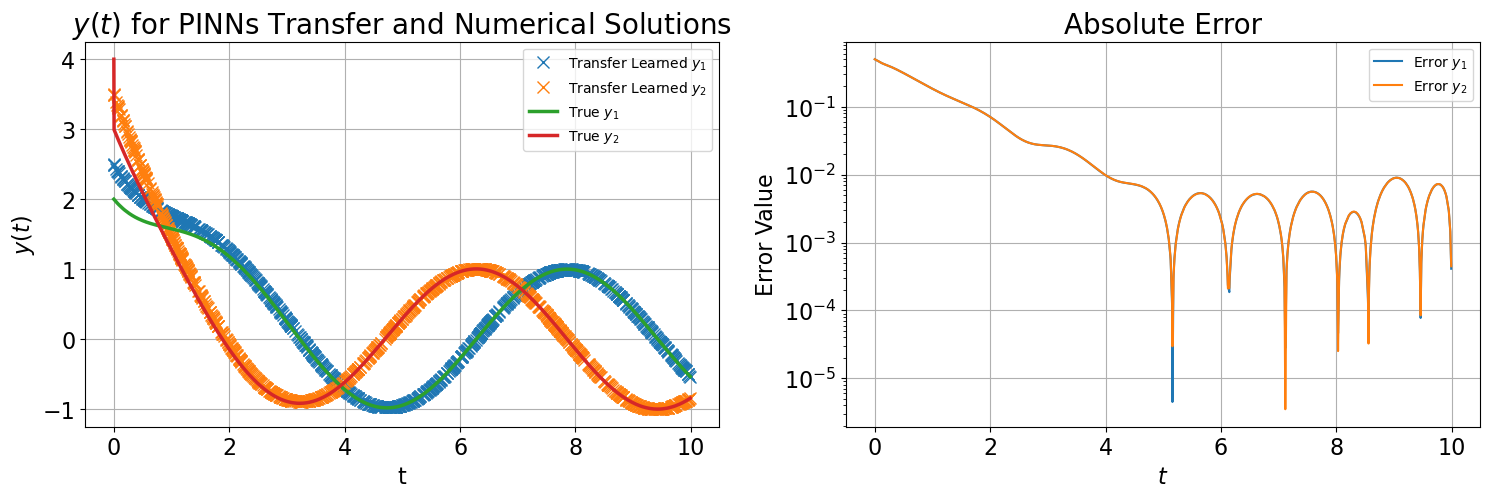

In [8]:
# stiff parameter alpha list
alpha_transfer = 10000

transfer_A = get_A(alpha_transfer)
force_transfer = lambda t, alpha=alpha_transfer: torch.vstack([2*torch.sin(t), alpha*(torch.cos(t)-torch.sin(t))]).T.double() \
    if not isinstance(t, (float, int)) \
    else np.array([2*np.sin(t), alpha*(np.cos(t)-np.sin(t))]).T

IC_transfer = v_list[0]

# compute the transfer learned solution
M_inv_new, W_out_new_A, force_terms_new, total_time = analytically_compute_weights(dH_dt_new, H, H_0, t_eval,
                                                                       IC_transfer, transfer_A, force_transfer)

# plot the transfer learned and true solutions
plot_transfer_learned_and_analytical(H, W_out_new_A, t_eval, IC_transfer, transfer_A, force_transfer,
                                     num_equations, numerical_sol_fct_radau)

## Comparative analysis 

- Solve iteratively for several alpha value
- Solve with:
    - PINNS trasnfer learning (only A change)
    - RK45
    - Radeau
    - LSODA
- Get:
    - PINSS: Error + Time to compute
    - RK45: Error + Time to compute
    - Radau: Error + Time to compute
    - LSODA: Error + Time to compute

In [9]:
log_scale = True

In [10]:
import time
from collections import defaultdict
from tqdm import tqdm


alpha_list_transfer = [i for i in range(10, 155, 5)]
log_scale = False
# alpha_list_transfer = [i for i in range(2, 41, 2)]

computational_time = defaultdict(list)
max_error = defaultdict(list)
mean_error = defaultdict(list)

solution = defaultdict(list)

length = t_eval.shape[0]

for alpha in tqdm(alpha_list_transfer):

    transfer_A = get_A(alpha)
    force_transfer = lambda t, alpha=alpha: torch.vstack([2*torch.sin(t), alpha*(torch.cos(t)-torch.sin(t))]).T.double() \
    if not isinstance(t, (float, int)) \
    else np.array([2*np.sin(t), alpha*(np.cos(t)-np.sin(t))]).T


    # solve with PINNS
    M_inv_new, W_out_new_A, force_terms_new, total_time = analytically_compute_weights(dH_dt_new, H, H_0, t_eval,
                                                                                       v, transfer_A, force_transfer,
                                                                                       verbose=False)
    pinns_sol = torch.matmul(H.double(), W_out_new_A.double())
    solution["PINNS"].append(np.swapaxes(pinns_sol.detach().cpu().numpy().squeeze(), 0, 1))
    computational_time["PINNS"].append(total_time)

    # solve with numerical methods
    for method, fct in numerical_methods.items():
        start = time.time()
        numerical_sol = fct(t_eval.detach().cpu().numpy(), v.detach().cpu(),
                            transfer_A.cpu(),
                            force_transfer)
        solution[method].append(numerical_sol)
        end = time.time()
        computational_time[method].append(end-start)

100%|██████████| 29/29 [00:19<00:00,  1.50it/s]


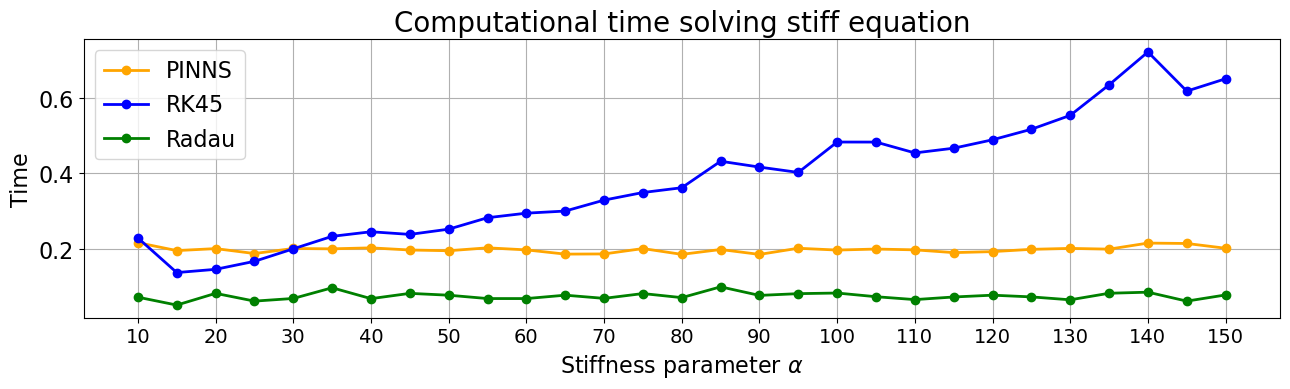

In [11]:
color = {"PINNS": 'orange', "RK45": 'b', "Radau": 'g', 'LSODA': 'm', "True": (1, 0, 0, 0.5)}
fig, ax = plt.subplots(1, tight_layout=True, figsize=(13, 4))

for method, time in computational_time.items():
    ax.plot(alpha_list_transfer, time, "-o", color=color[method], label=f"{method}", linewidth=2 )

#ax.set_yscale("log")
if log_scale: ax.set_xscale("log")
ax.set_title("Computational time solving stiff equation", fontsize=20)
ax.set_xlabel(r'Stiffness parameter $\alpha$', fontsize=16)
ax.set_ylabel('Time', fontsize=16)
ax.set_xticks(alpha_list_transfer[::2])
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=16)
ax.legend(loc='best', fontsize=16)
ax.grid()

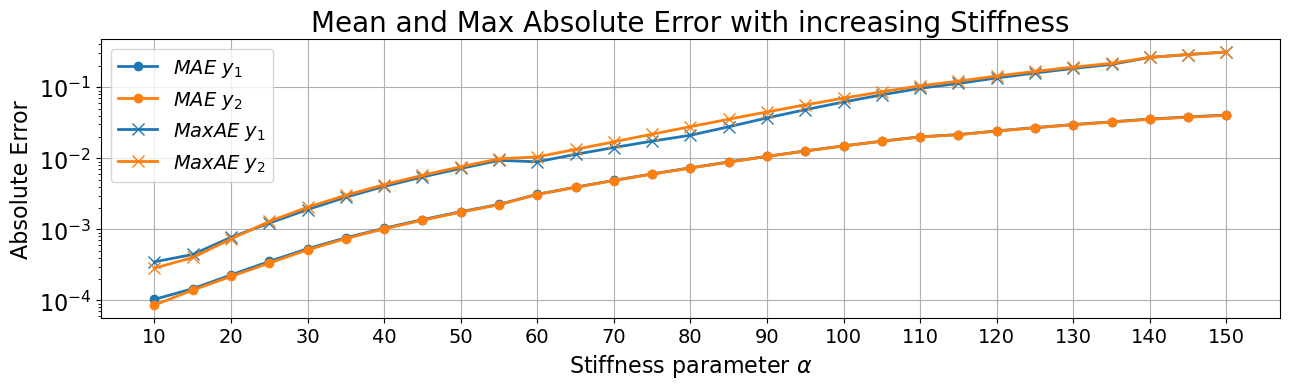

In [12]:
fig, ax = plt.subplots(1, tight_layout=True, figsize=(13, 4))

ax.plot(alpha_list_transfer,
        np.abs(np.array(solution["PINNS"])-np.array(solution["Radau"])).mean(2)[:, 0],
        "-o", label="$MAE$ ${y_1}$", linewidth=2, markersize=6)

ax.plot(alpha_list_transfer,
        np.abs(np.array(solution["PINNS"])-np.array(solution["Radau"])).mean(2)[:, 1],
        "-o", label="$MAE$ ${y_2}$", linewidth=2, markersize=6)


ax.plot(alpha_list_transfer,
        np.abs(np.array(solution["PINNS"])-np.array(solution["Radau"])).max(2)[:, 0],
        "-x", color="#1f77b4", label="$MaxAE$ ${y_1}$", linewidth=2, markersize=8)

ax.plot(alpha_list_transfer,
        np.abs(np.array(solution["PINNS"])-np.array(solution["Radau"])).max(2)[:, 1],
        "-x", color="#ff7f0e", label="$MaxAE$ ${y_2}$", linewidth=2, markersize=8)

#ax.set_yscale("log")
if log_scale: ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title(r"Mean and Max Absolute Error with increasing Stiffness", fontsize=20)
ax.set_xlabel(r'Stiffness parameter $\alpha$', fontsize=16)
ax.set_ylabel('Absolute Error', fontsize=16)
ax.set_xticks(alpha_list_transfer[::2])
ax.grid()
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=16)
ax.legend(loc='best', fontsize=14)

In [13]:
import json

history = {}
history["alpha_list"] = alpha_list
history["mae_y1"] = np.abs(np.array(solution["PINNS"])-np.array(solution["Radau"])).mean(2)[:, 0].tolist()
history["mae_y2"] = np.abs(np.array(solution["PINNS"])-np.array(solution["Radau"])).mean(2)[:, 1].tolist()
history["maxae_y1"] = np.abs(np.array(solution["PINNS"])-np.array(solution["Radau"])).max(2)[:, 0].tolist()
history["maxae_y2"] = np.abs(np.array(solution["PINNS"])-np.array(solution["Radau"])).max(2)[:, 1].tolist()

with open(r"D:\Emilien\Documents\Cours\Master_Thesis\Harvard_Master_Thesis\result_history\Example1_Error_Transfer.json",  "w") as fp:
    json.dump(history, fp)